# Кластеризация.

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Цель

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Так же
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('geo.xlsx')

In [4]:
data_p = data[data.comment_class==1]
data_n = data[data.comment_class==-1]
data.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [5]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95147 entries, 0 to 108805
Data columns (total 3 columns):
x                95147 non-null float64
y                95147 non-null float64
comment_class    95147 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.9 MB


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams

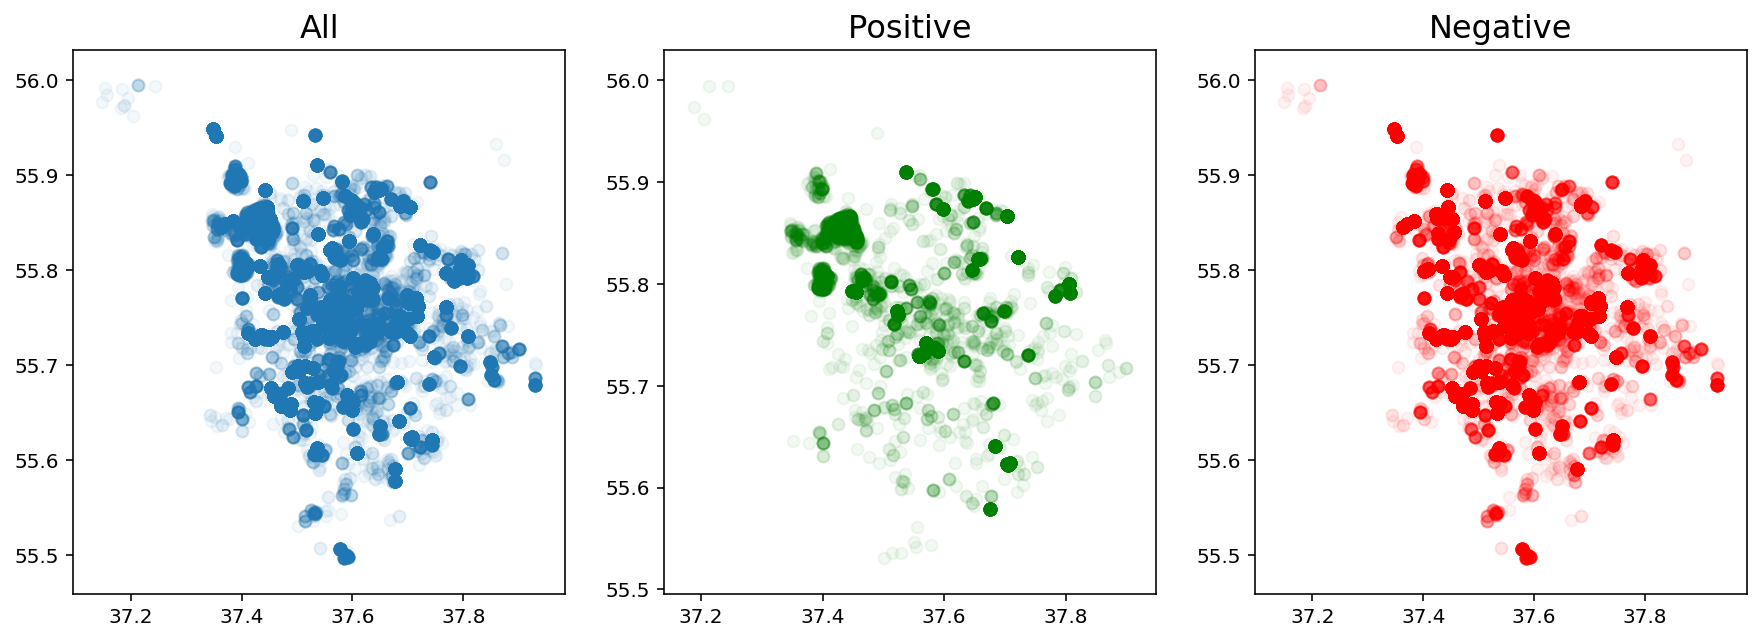

In [7]:
# отобразим плохие и хорошие голоса на карте
rcParams['figure.figsize'] = (5, 5)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))           # quantity rows and columns (and size)

ax1.scatter(x=data.x, y=data.y, alpha=0.05)
ax2.scatter(x=data_p.x, y=data_p.y, alpha=0.05, color='g')
ax3.scatter(x=data_n.x, y=data_n.y, alpha=0.05, color='r')

titles = ["All", "Positive", "Negative"]
colors = ["b", "g", "r"]
all_data = [data, data_p, data_n]

for number, title in zip (fig.axes, titles):
    number.set_title(title, fontsize=16)

In [8]:
from sklearn.cluster import KMeans, DBSCAN

## Сначала сделаем кластеризацию с KMeans

In [9]:
data_prob = data.drop('comment_class', axis=1)
km = KMeans(n_clusters=8)
km.fit(data_prob)
clusters = km.predict(data_prob)

In [10]:
for i in range(8):
    print (i,'cluster =',len(data_prob[clusters==i]))

0 cluster = 12584
1 cluster = 17160
2 cluster = 20462
3 cluster = 17073
4 cluster = 24251
5 cluster = 3508
6 cluster = 10040
7 cluster = 3728


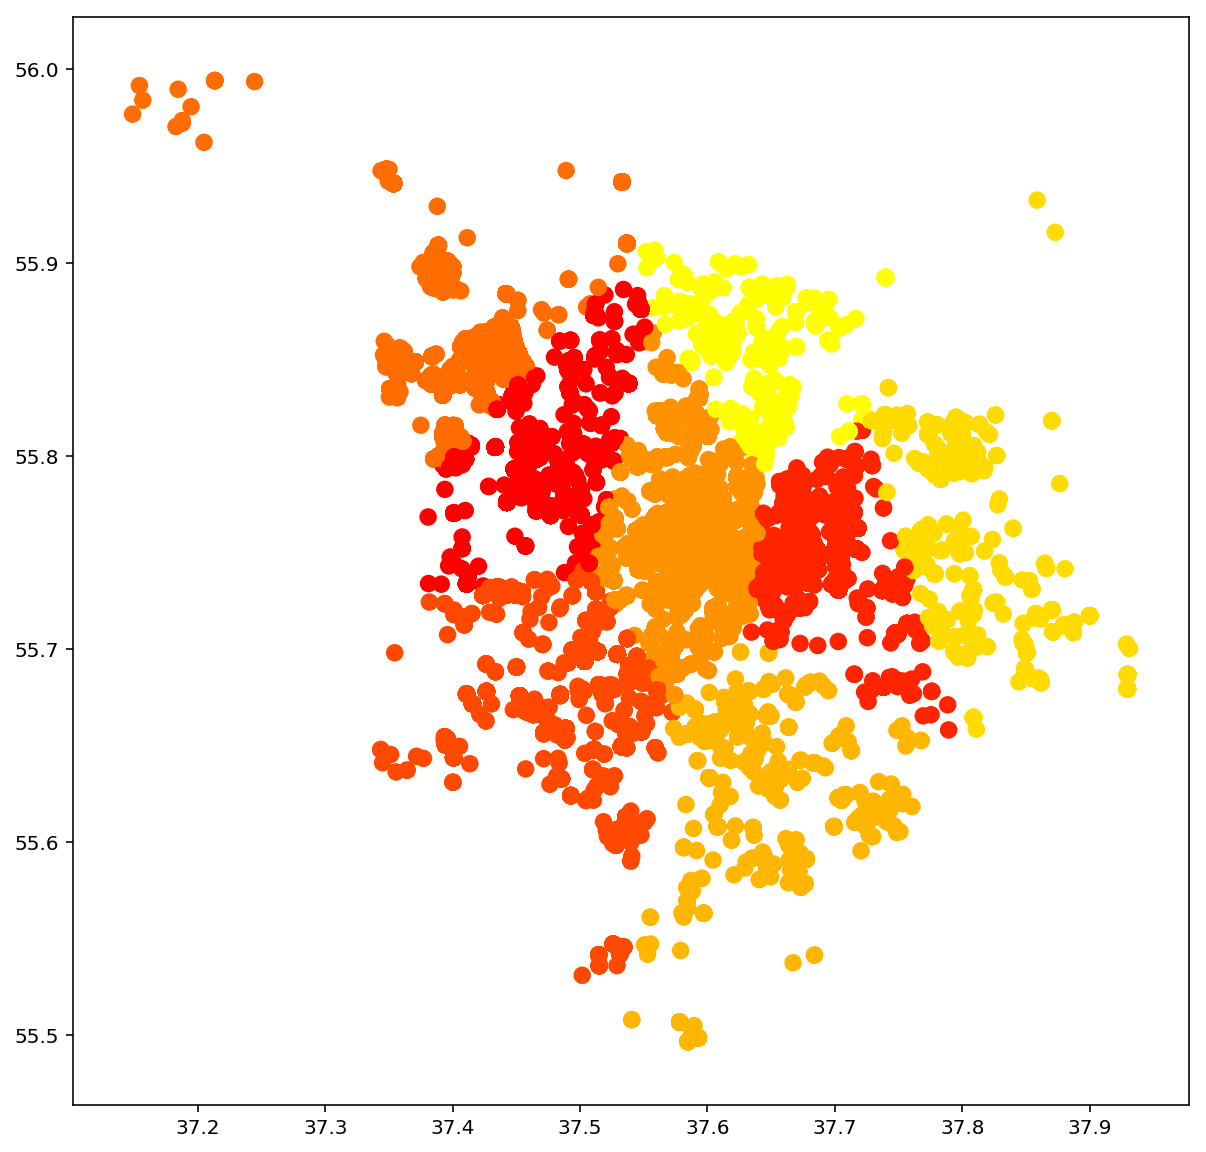

In [11]:
rcParams['figure.figsize'] = (10, 10)

#            РАБОЧИЙ, НО БОЛЕЕ ДЛИННЫЙ ВАРИАНТ
# for i,color in zip(range(8),{'blue','red','green','black','orange','yellow','brown','orchid','lime'}):
#     x_i = data_prob.x[clusters==i]
#     y_i = data_prob.y[clusters==i]
#     plt.plot(x_i, y_i, 'ro', alpha=0.1, c=color)
    

plt.scatter(data_prob.x, data_prob.y, c=clusters, cmap='autumn', s=60)

### теперь определим оптимальное число кластеров

In [12]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_km = KMeans(n_clusters=k)
    clusters_km = clf_km.fit_predict(data_prob, )
    k_inertia.append(clf_km.inertia_/100)

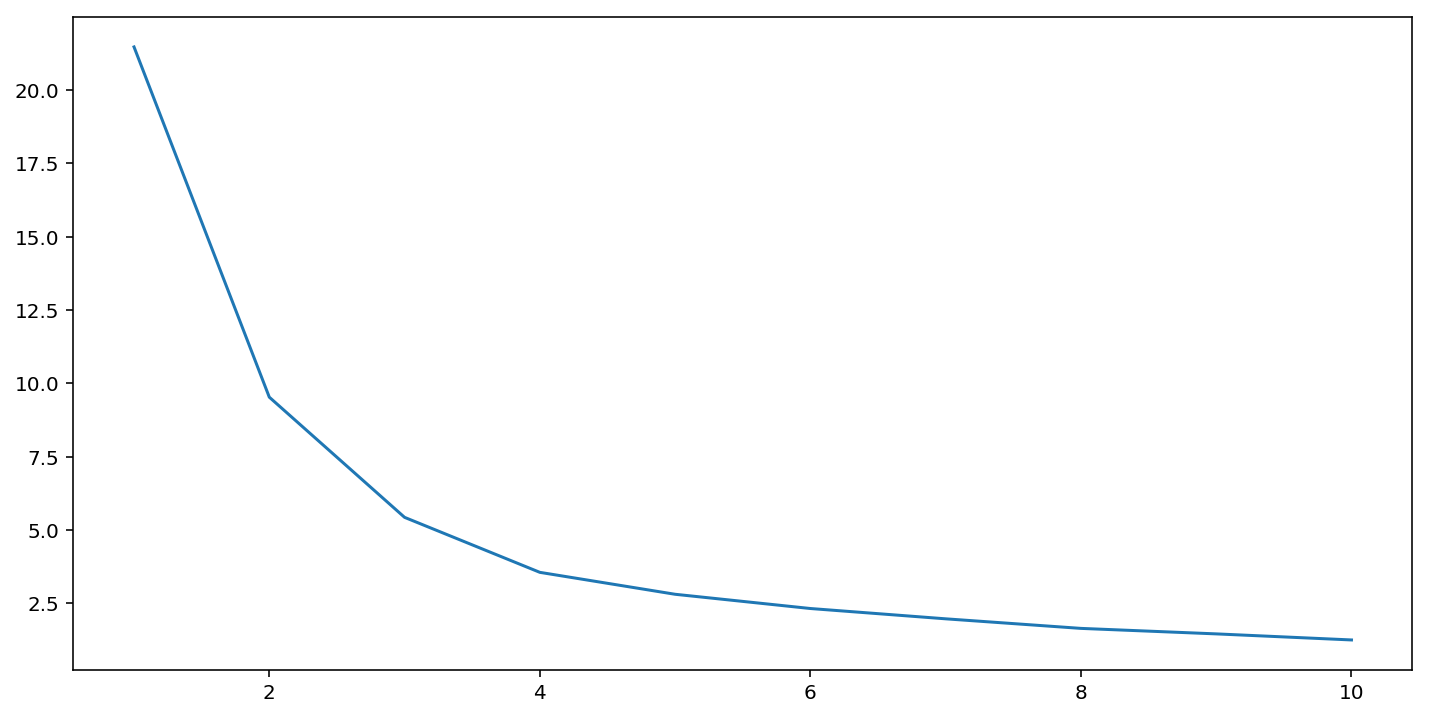

In [13]:
rcParams['figure.figsize'] = (12,6)
plt.plot(ks, k_inertia)

In [14]:
diff = np.diff(k_inertia)           # np.diff - вычислить N-ю дискретную разность по заданной оси

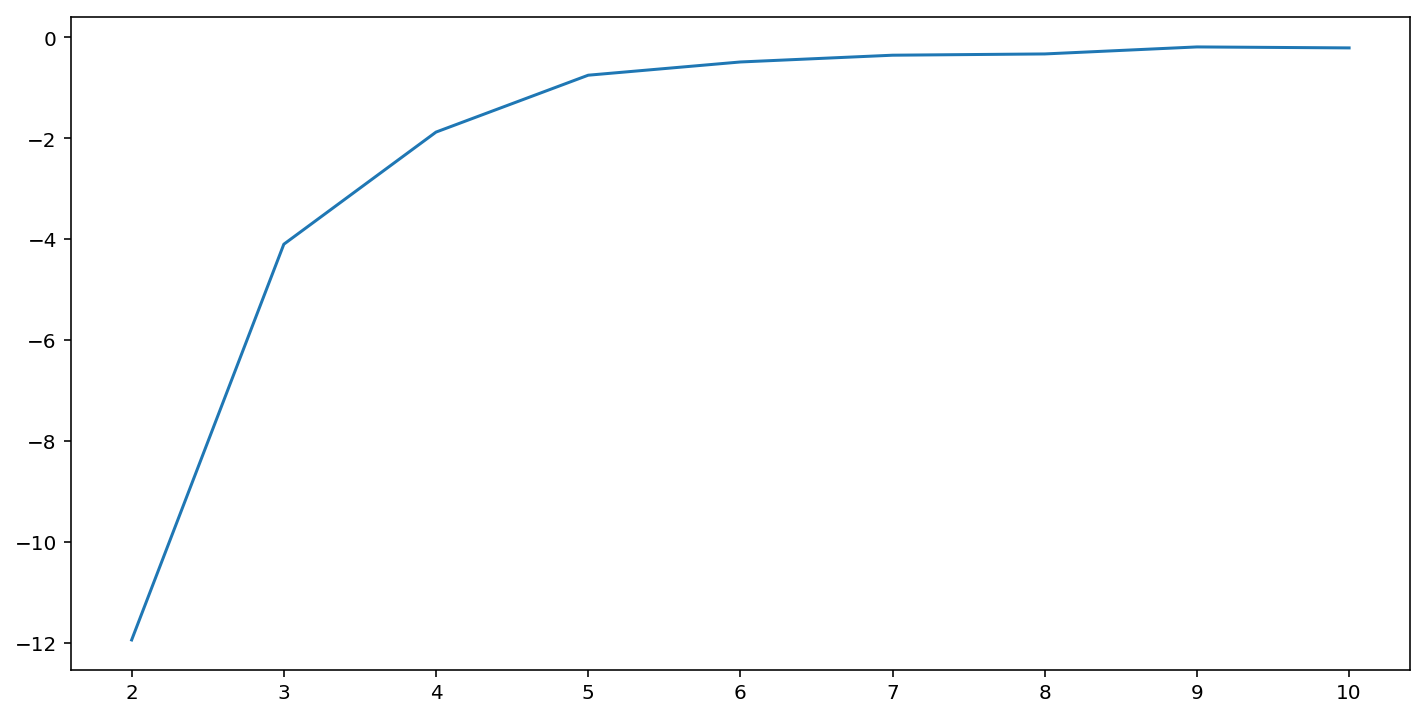

In [15]:
plt.plot(ks[1:], diff)

Исходя из графика, количество кластеров можно было бы оставить 3

Теперь найдём оптимальное число кластеров по этой формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [16]:
diff_r = diff[1:] / diff[:-1]

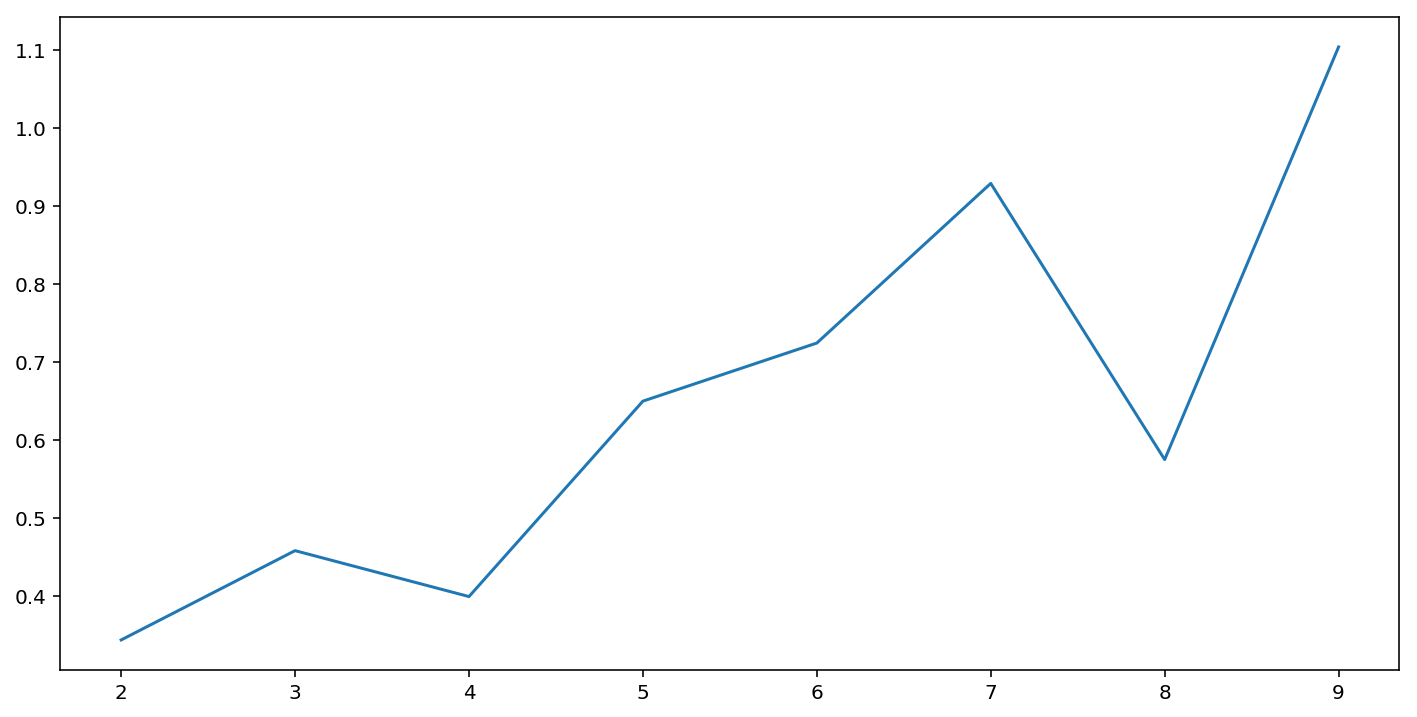

In [17]:
plt.plot(ks[1:-1], diff_r)

In [18]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

## Это достаточно субъективная оценка, потому будем перебирать дальше

In [19]:
from sklearn.metrics import silhouette_score
silhouette_score(data_prob, clusters)

0.5597276700852132

In [20]:
from sklearn.cluster import KMeans

In [21]:
data_p.head(3)

,x,y,comment_class
28,37.588916,55.741982,1
45,37.589311,55.734273,1
46,37.558526,55.728758,1


In [22]:
data_p_pr = data_p.drop('comment_class', axis=1)
data_n_pr = data_n.drop('comment_class', axis=1)

In [23]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_p_pr)
clusters_p = kmeans.predict(data_p_pr)

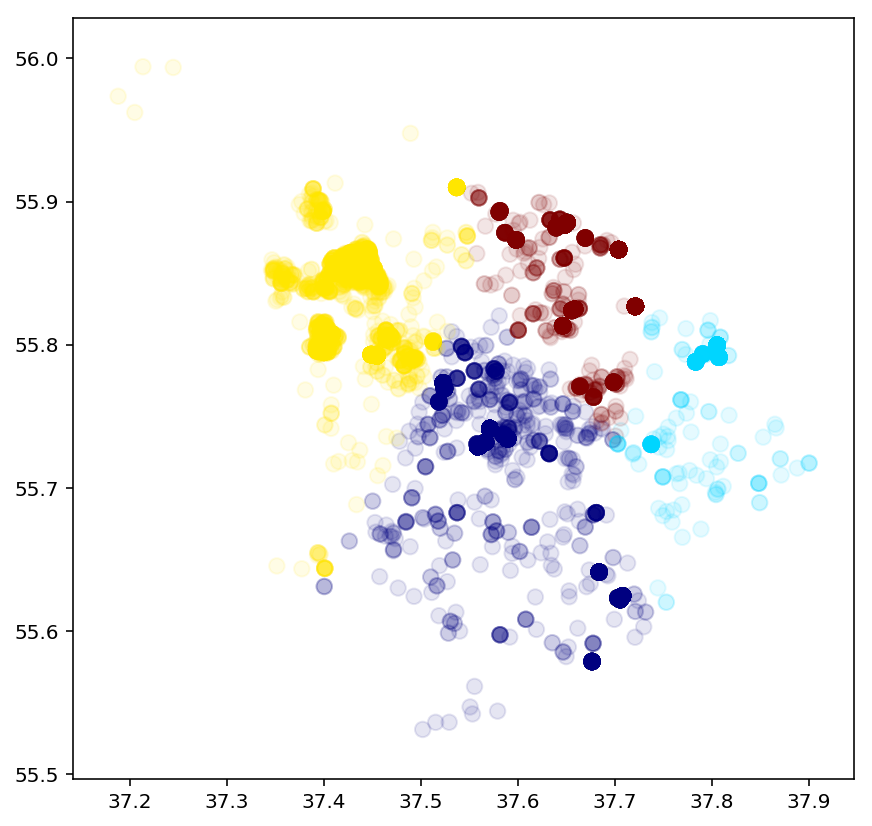

In [24]:
rcParams['figure.figsize'] = (7,7)
    
plt.scatter(data_p_pr.x, data_p_pr.y, c=clusters_p, alpha=0.1, cmap='jet', s=60)

In [25]:
kn_n = KMeans(n_clusters=8)
clusters_n = kn_n.fit_predict(data_n_pr)

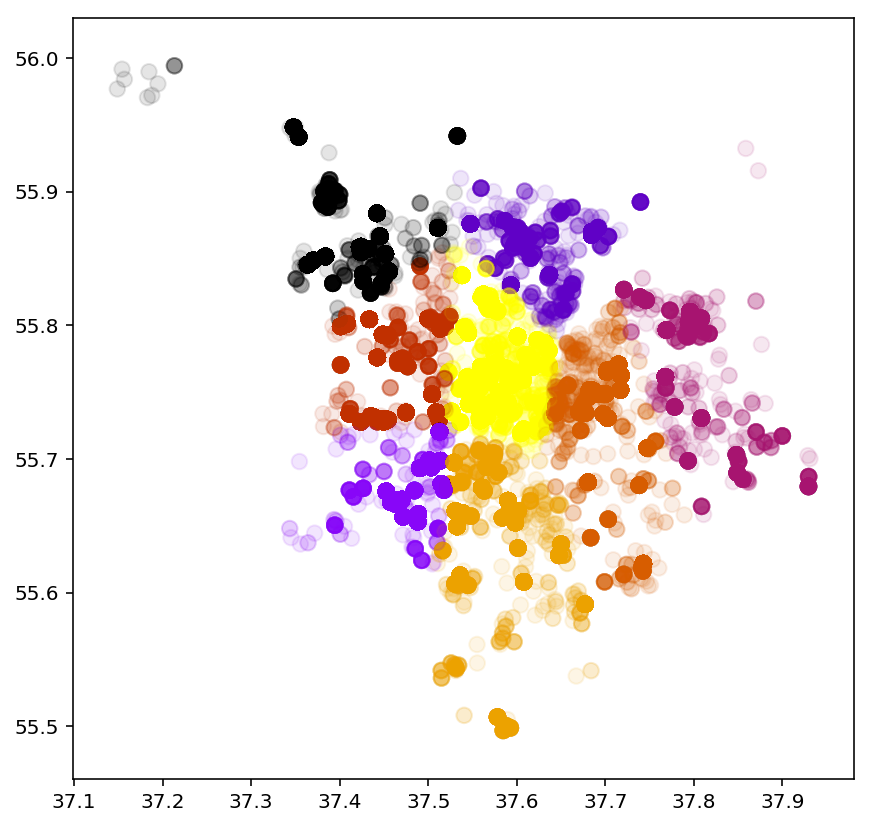

In [26]:
rcParams['figure.figsize'] = (7,7)
plt.scatter(data_n_pr.x, data_n_pr.y, c=clusters_n, alpha=0.1, cmap='gnuplot', s=60)

## Теперь используем DBSCAN

In [26]:
from sklearn.cluster import KMeans, DBSCAN

In [81]:
eps_ = np.array([0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1.2, 2.0, 3.0, 5.0])
min_samples_= np.array([5, 10, 50, 100, 300, 500, 1000, 2000])

In [82]:
# Так как на всей выборки считать слишком долго, возьмем лишь часть
choice = np.random.choice(data_prob.index, size=30000, replace=False).tolist()
data_x = data_prob[data_prob.index.isin(choice)]

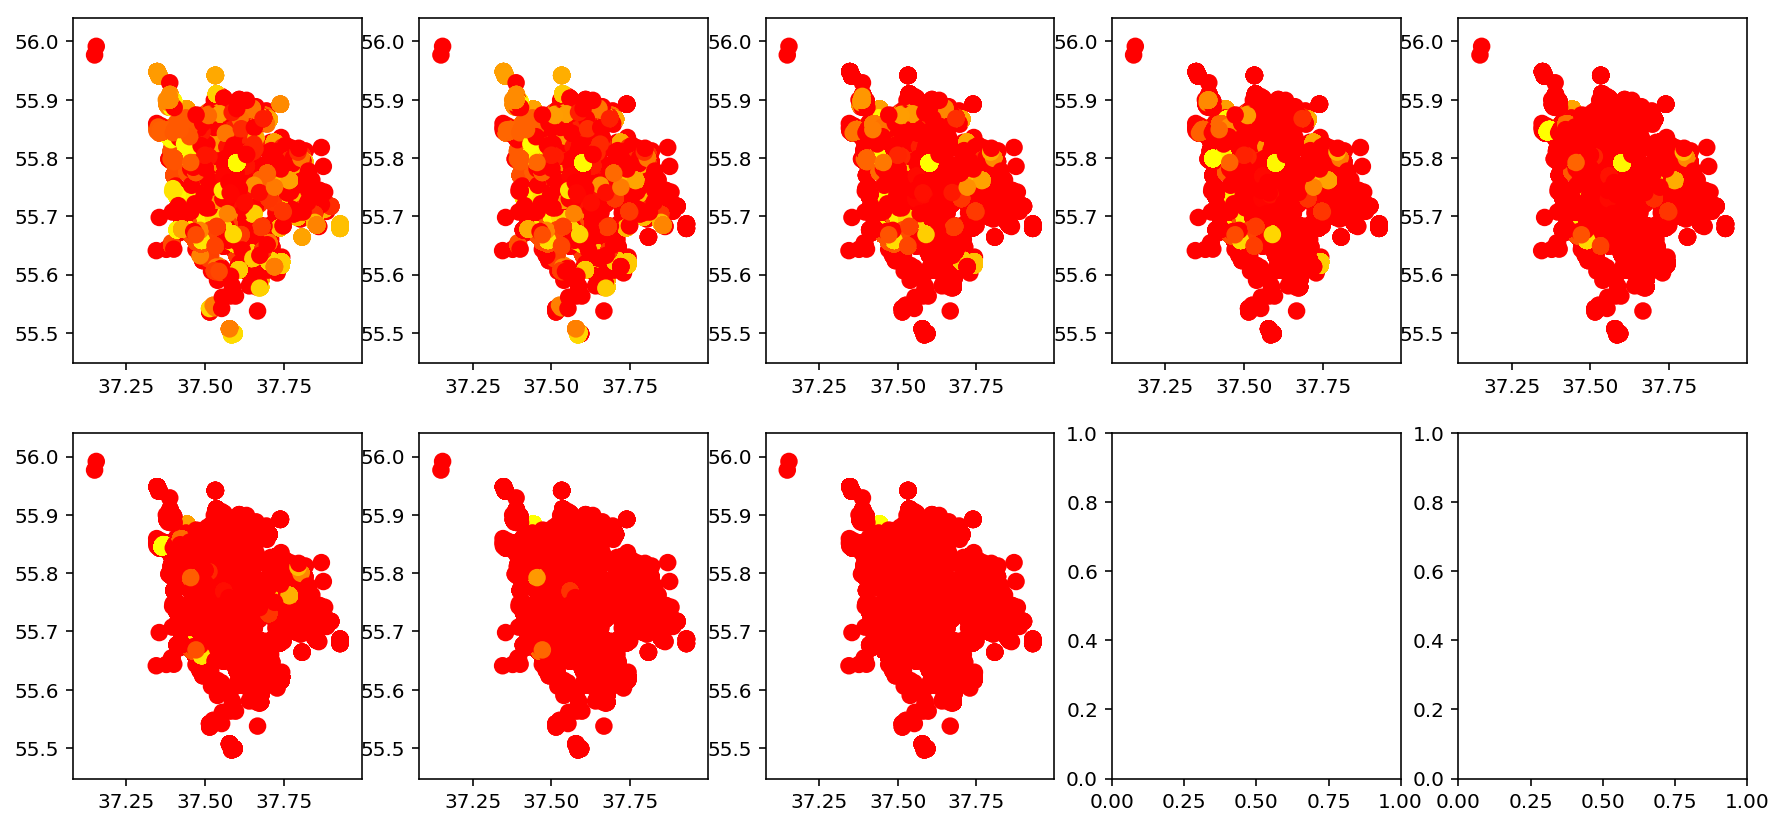

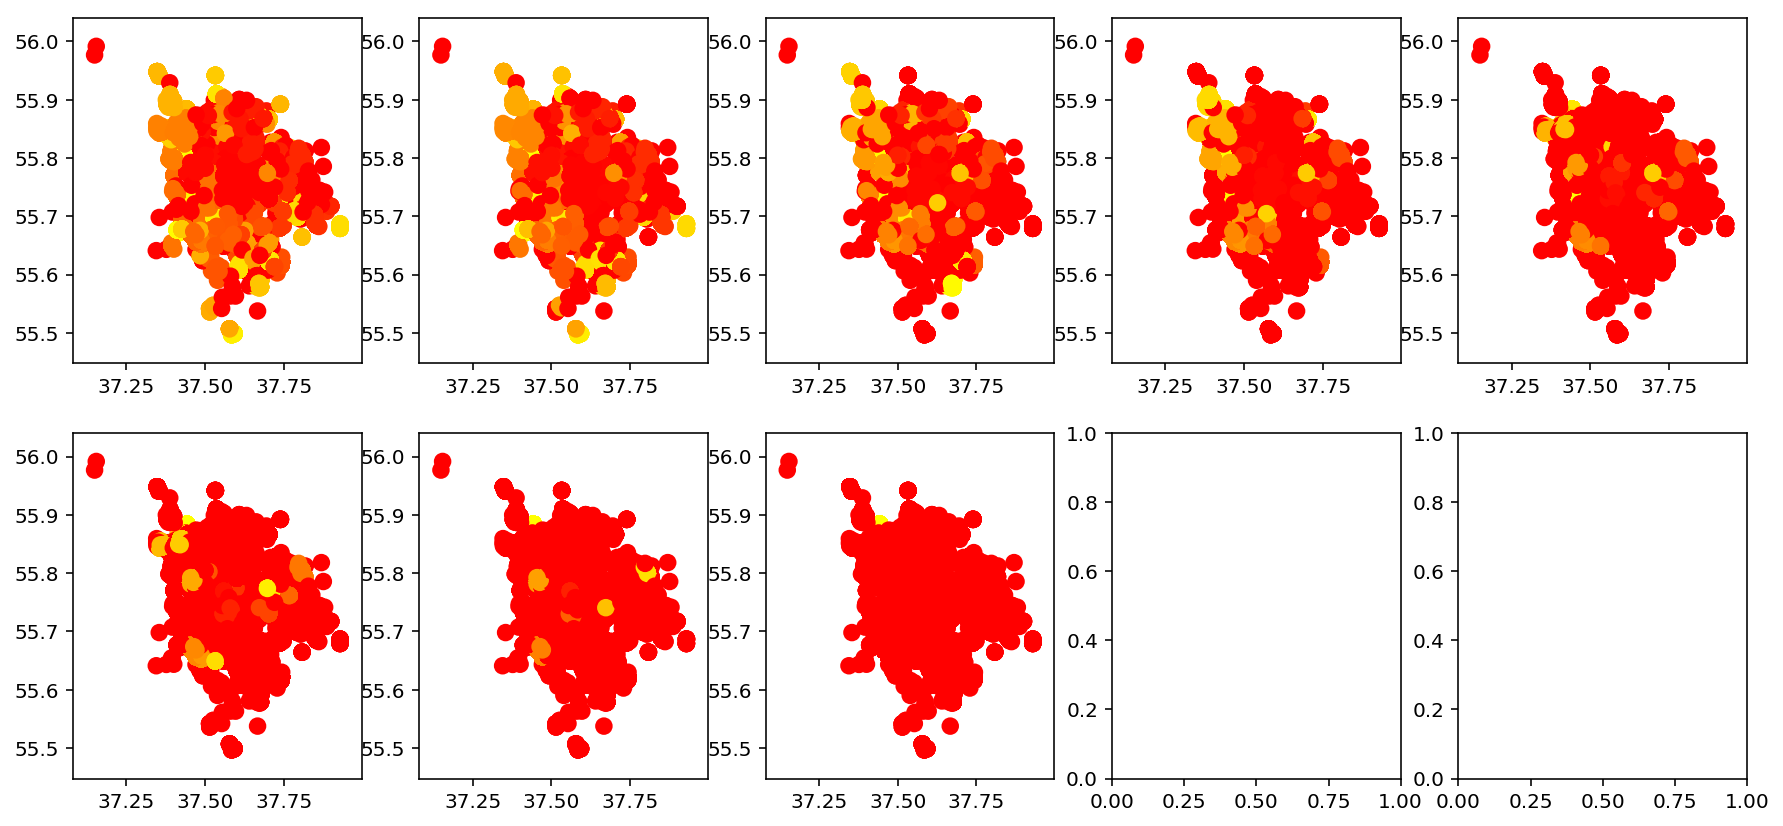

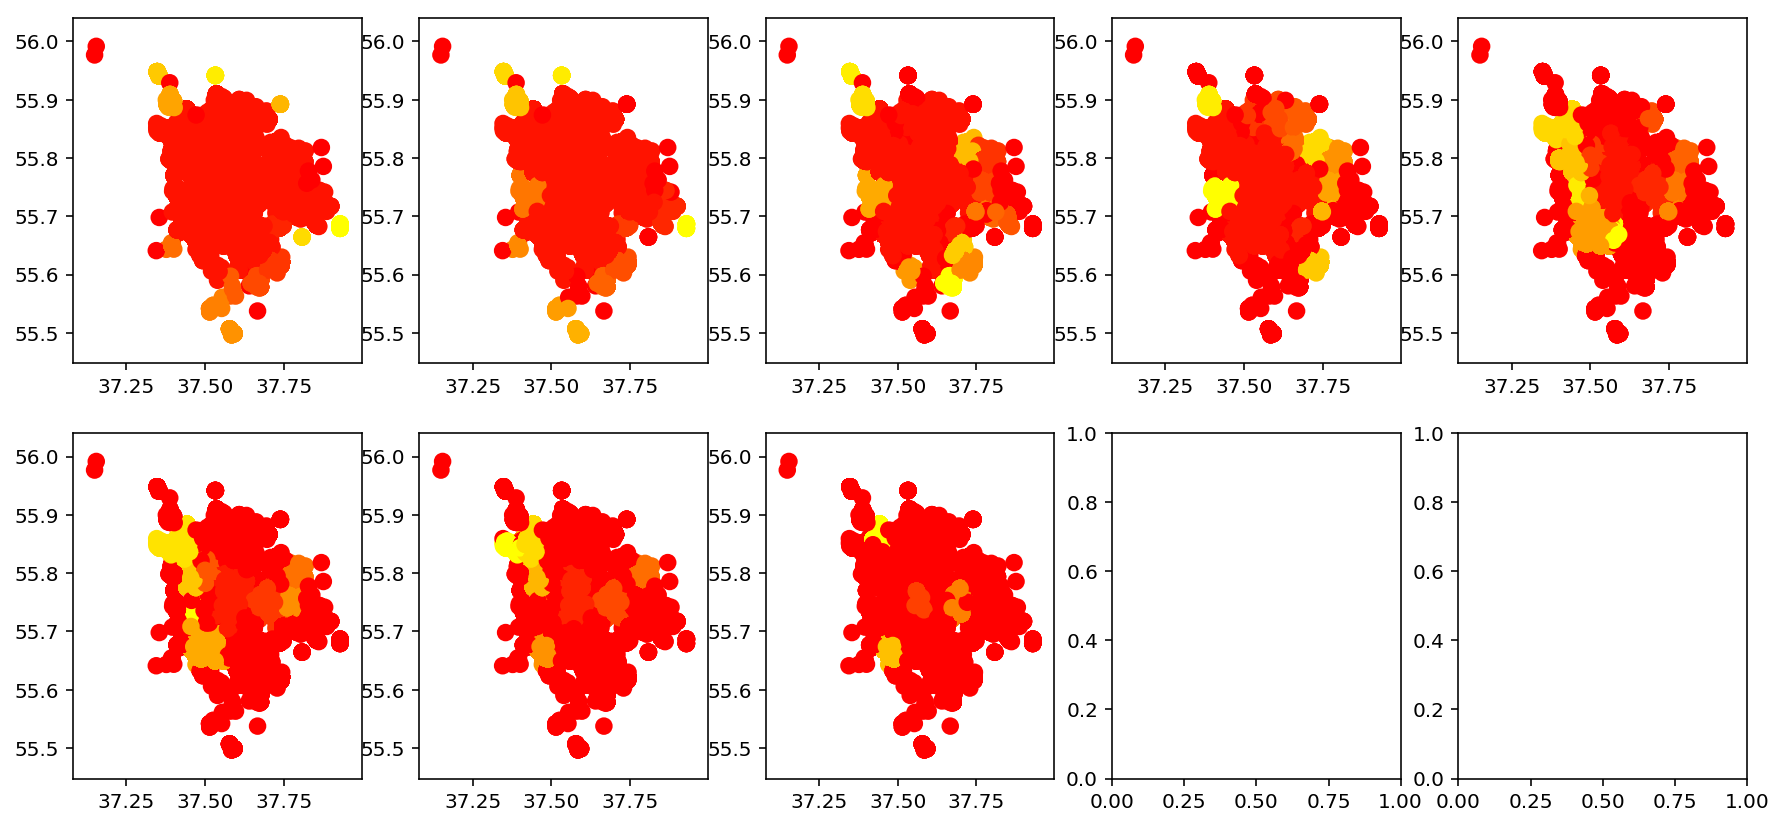

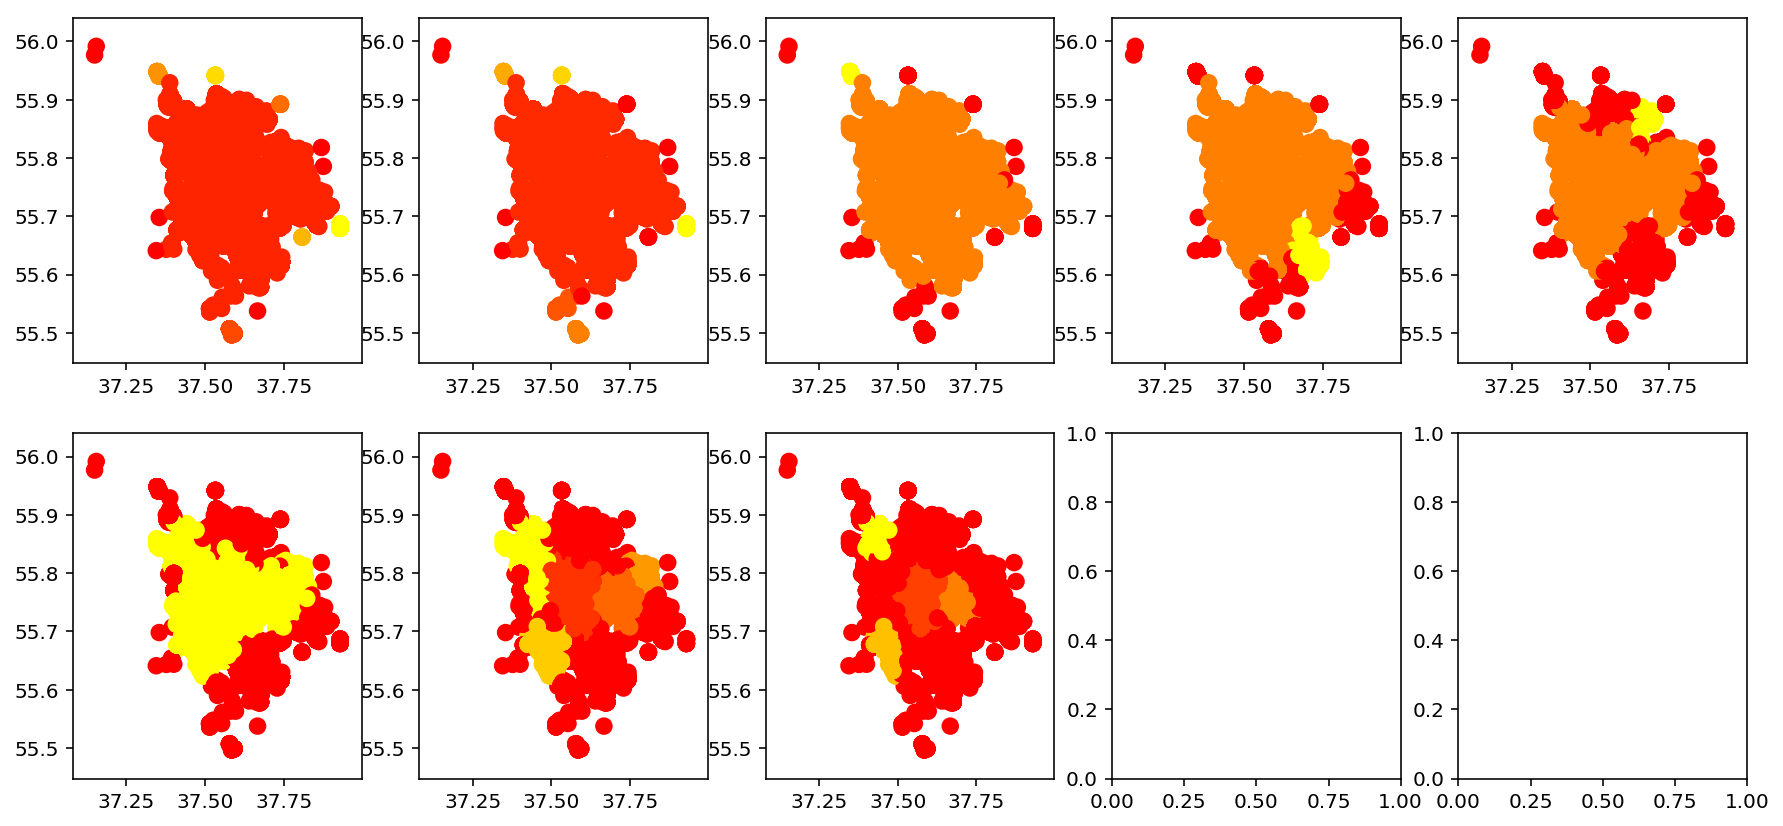

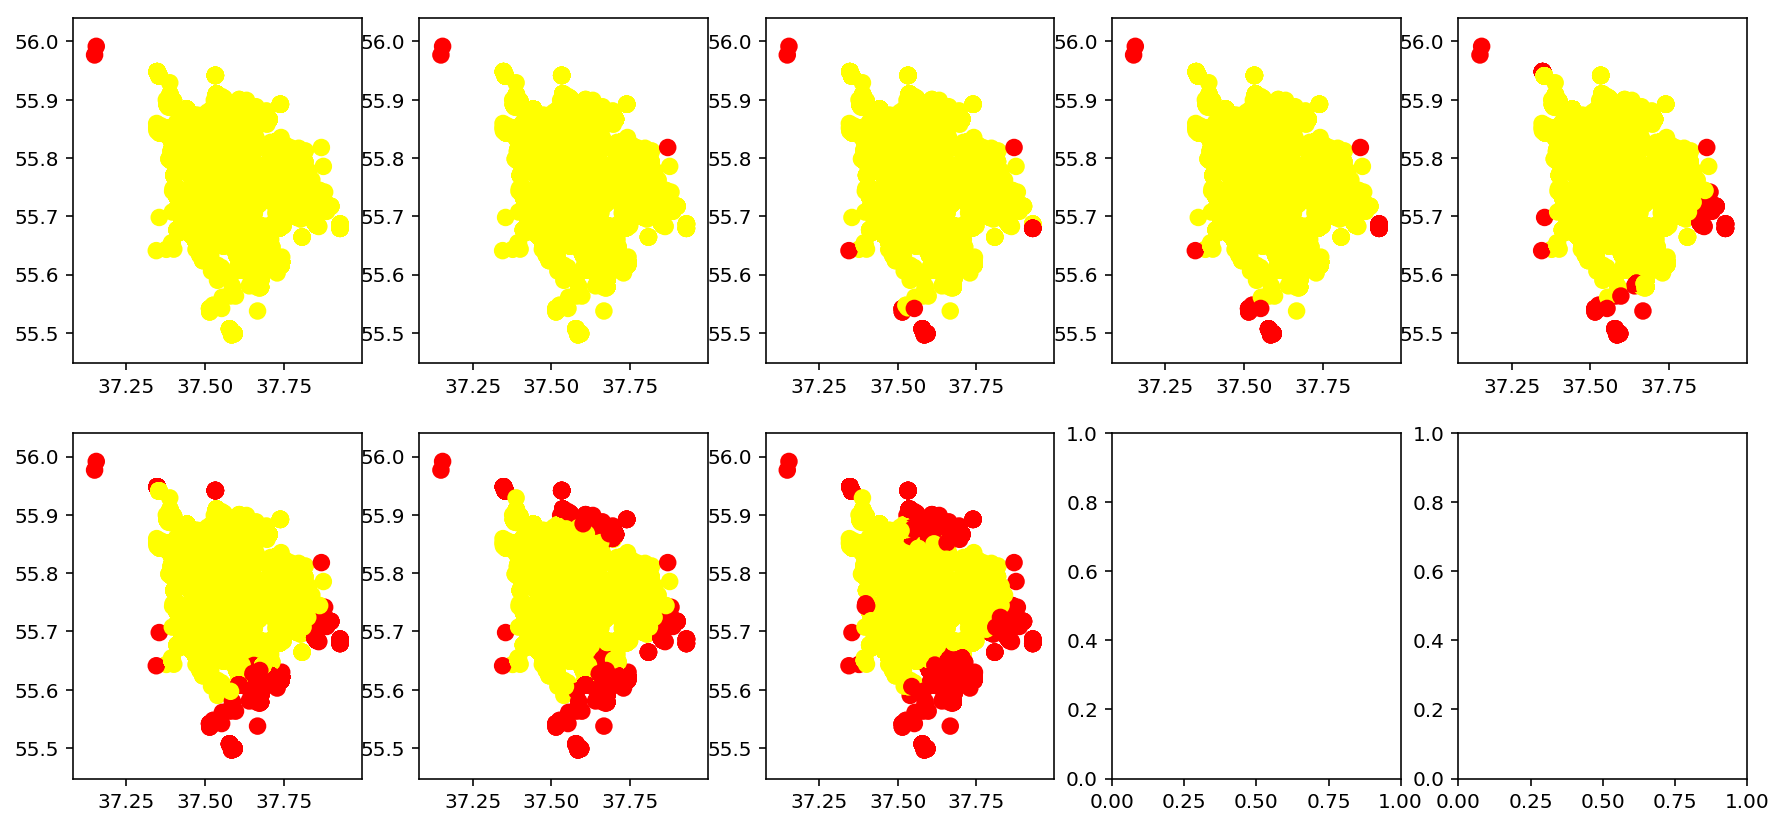

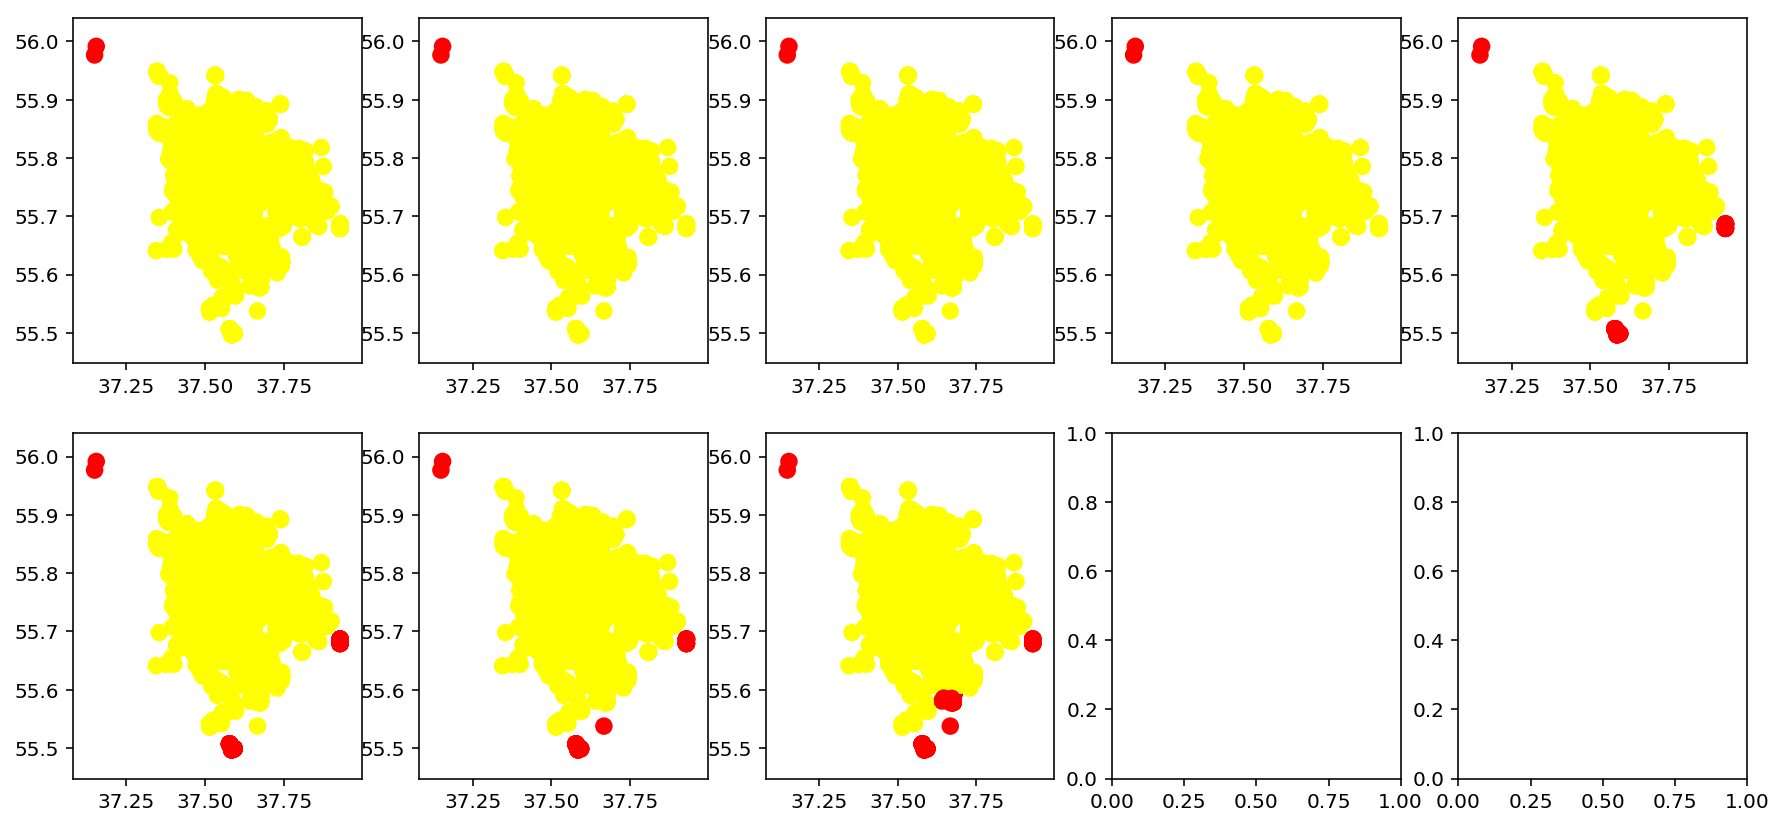

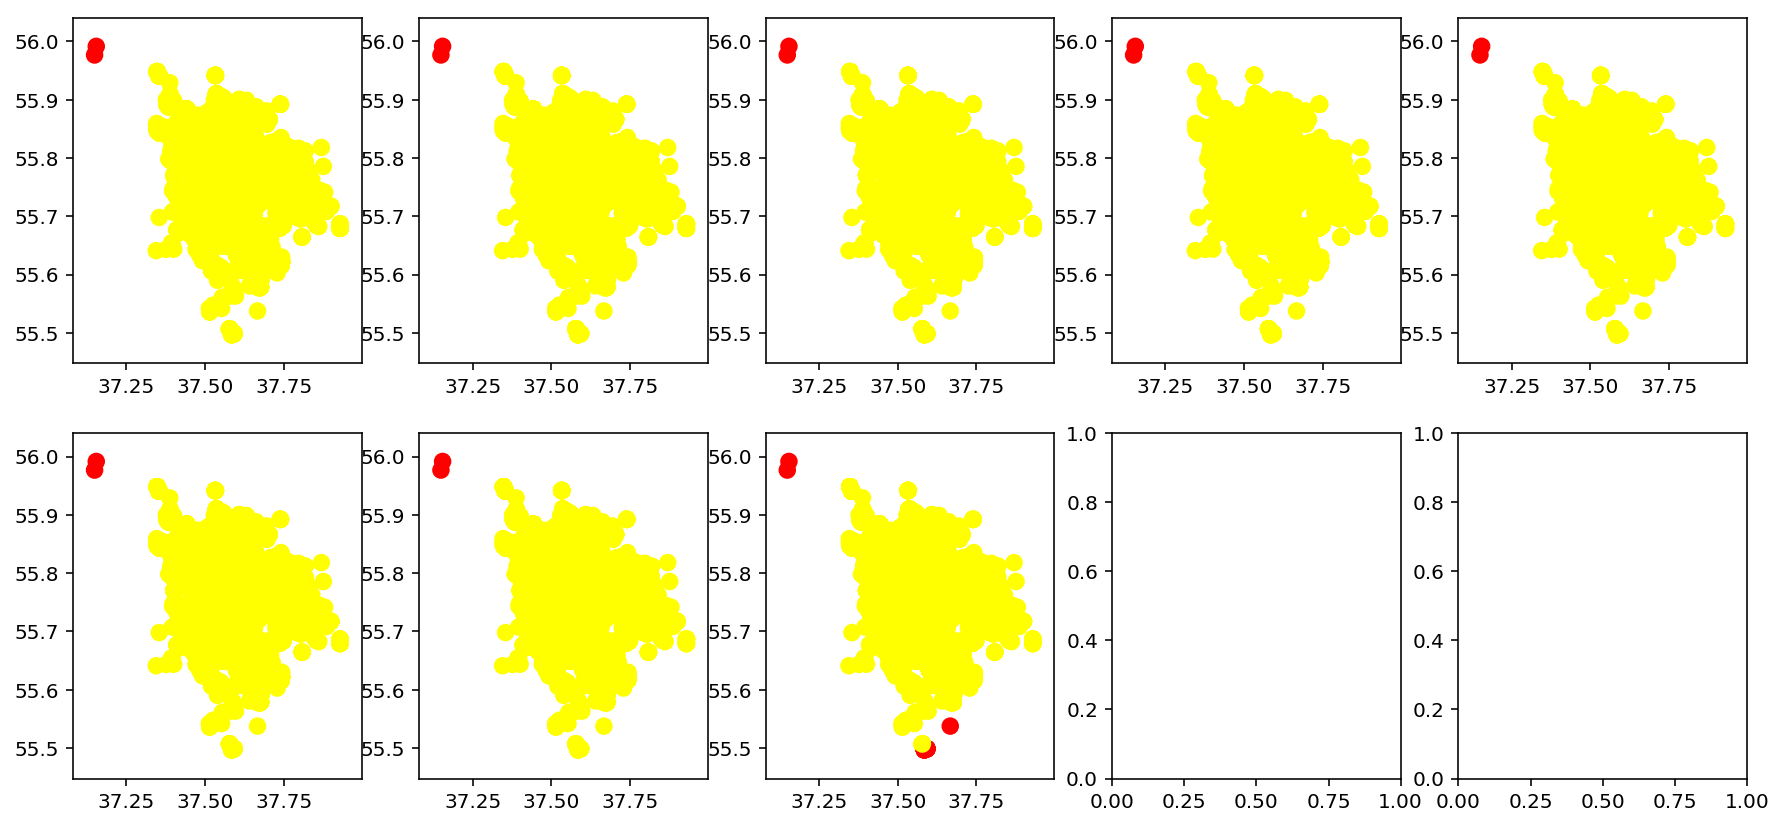

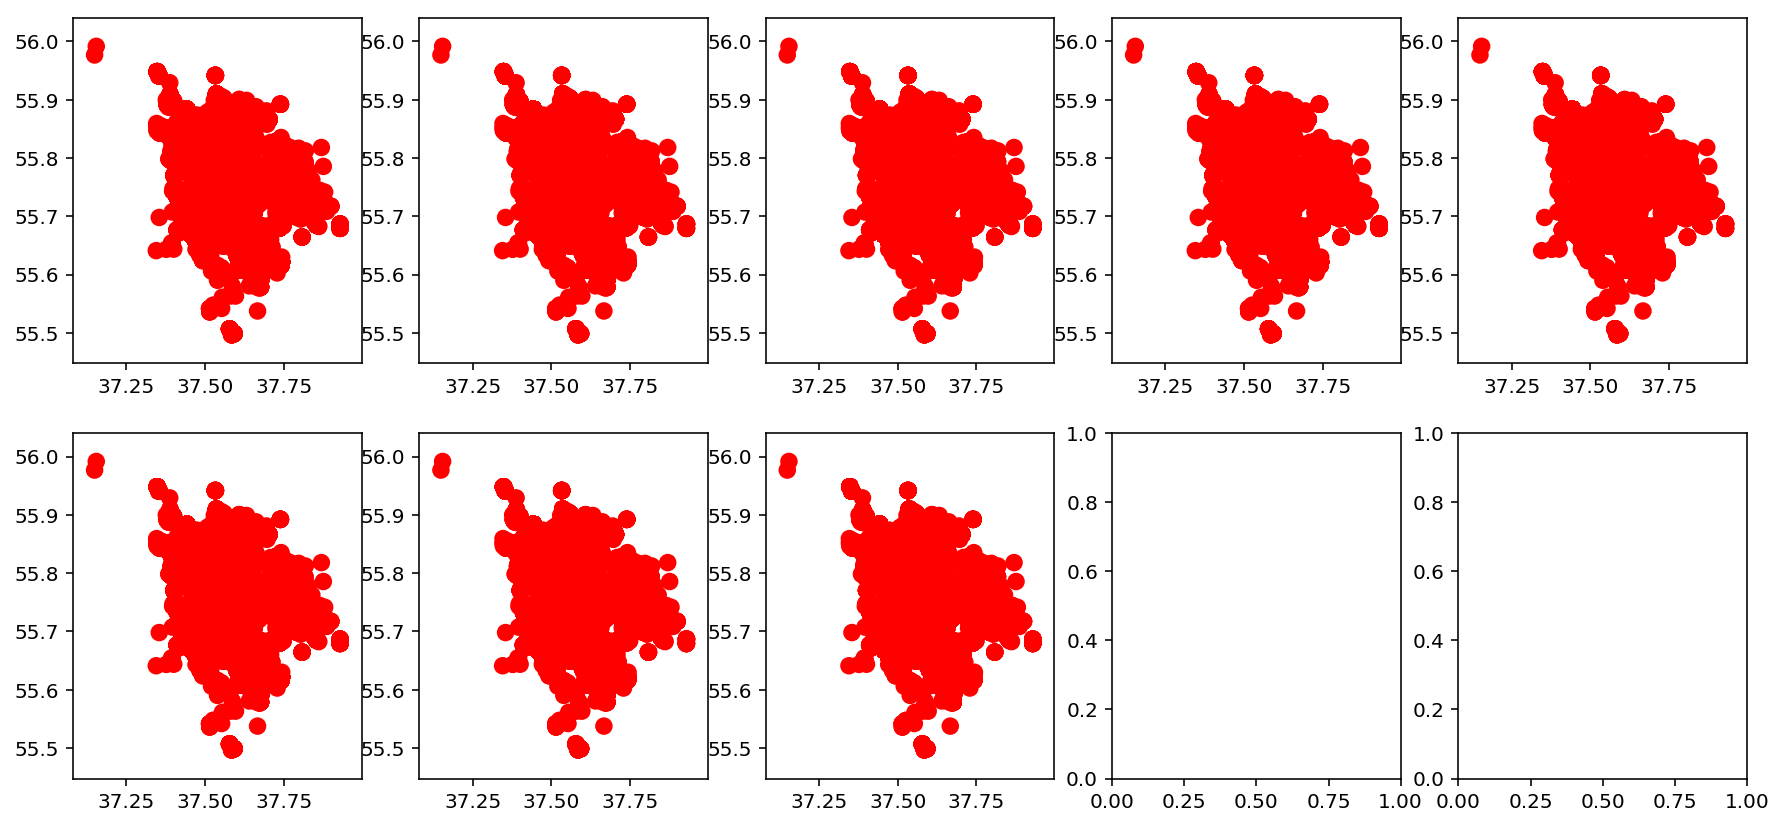

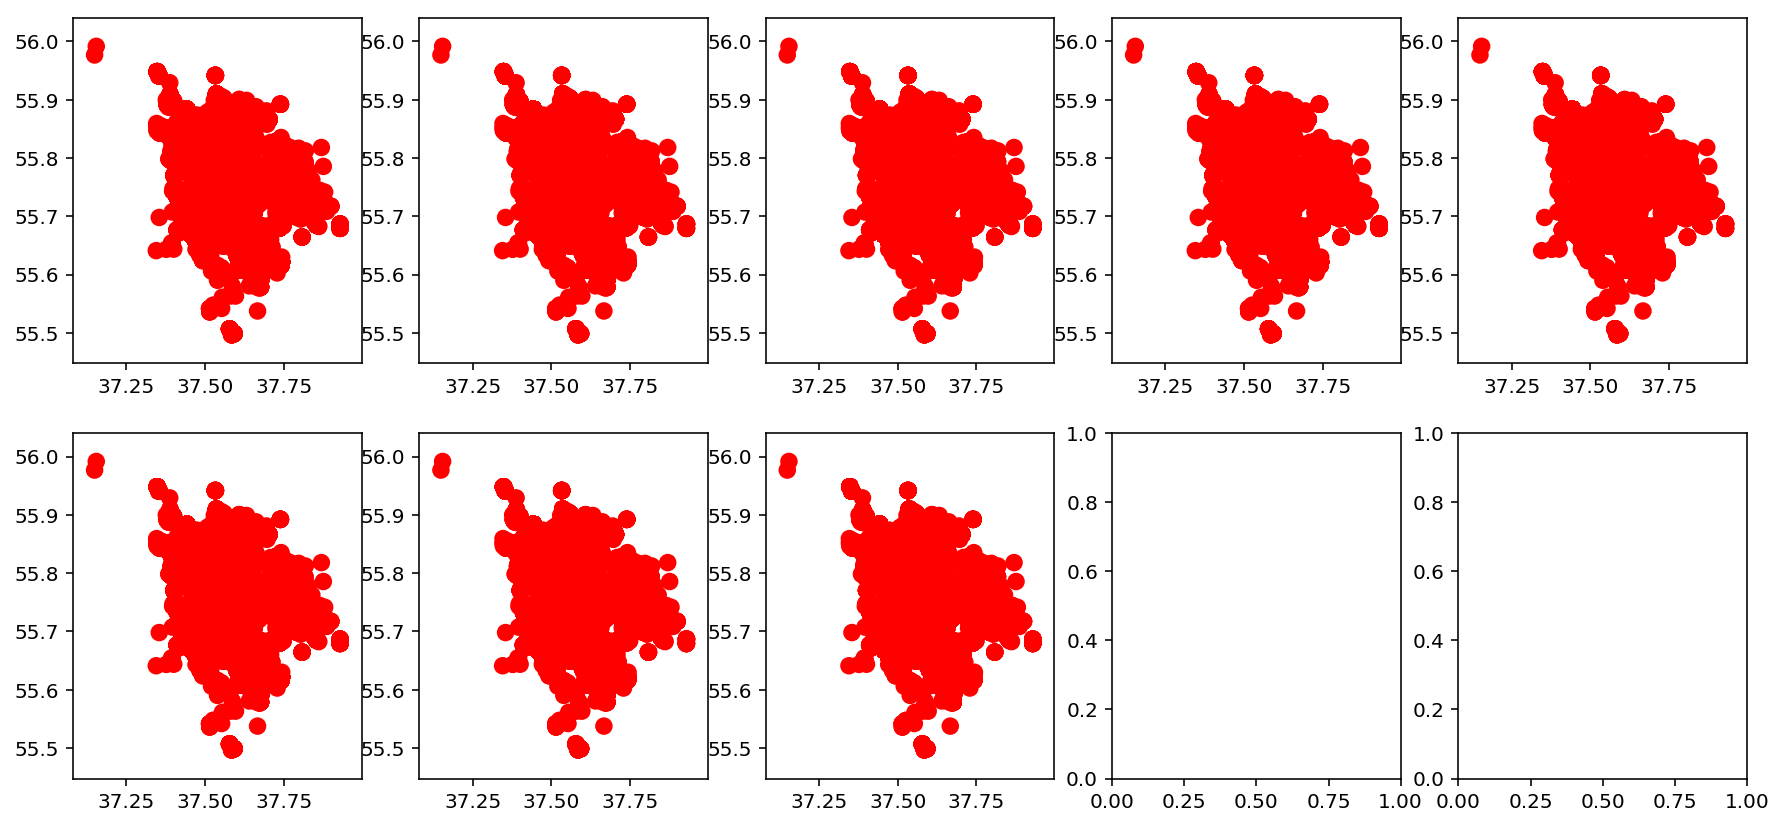

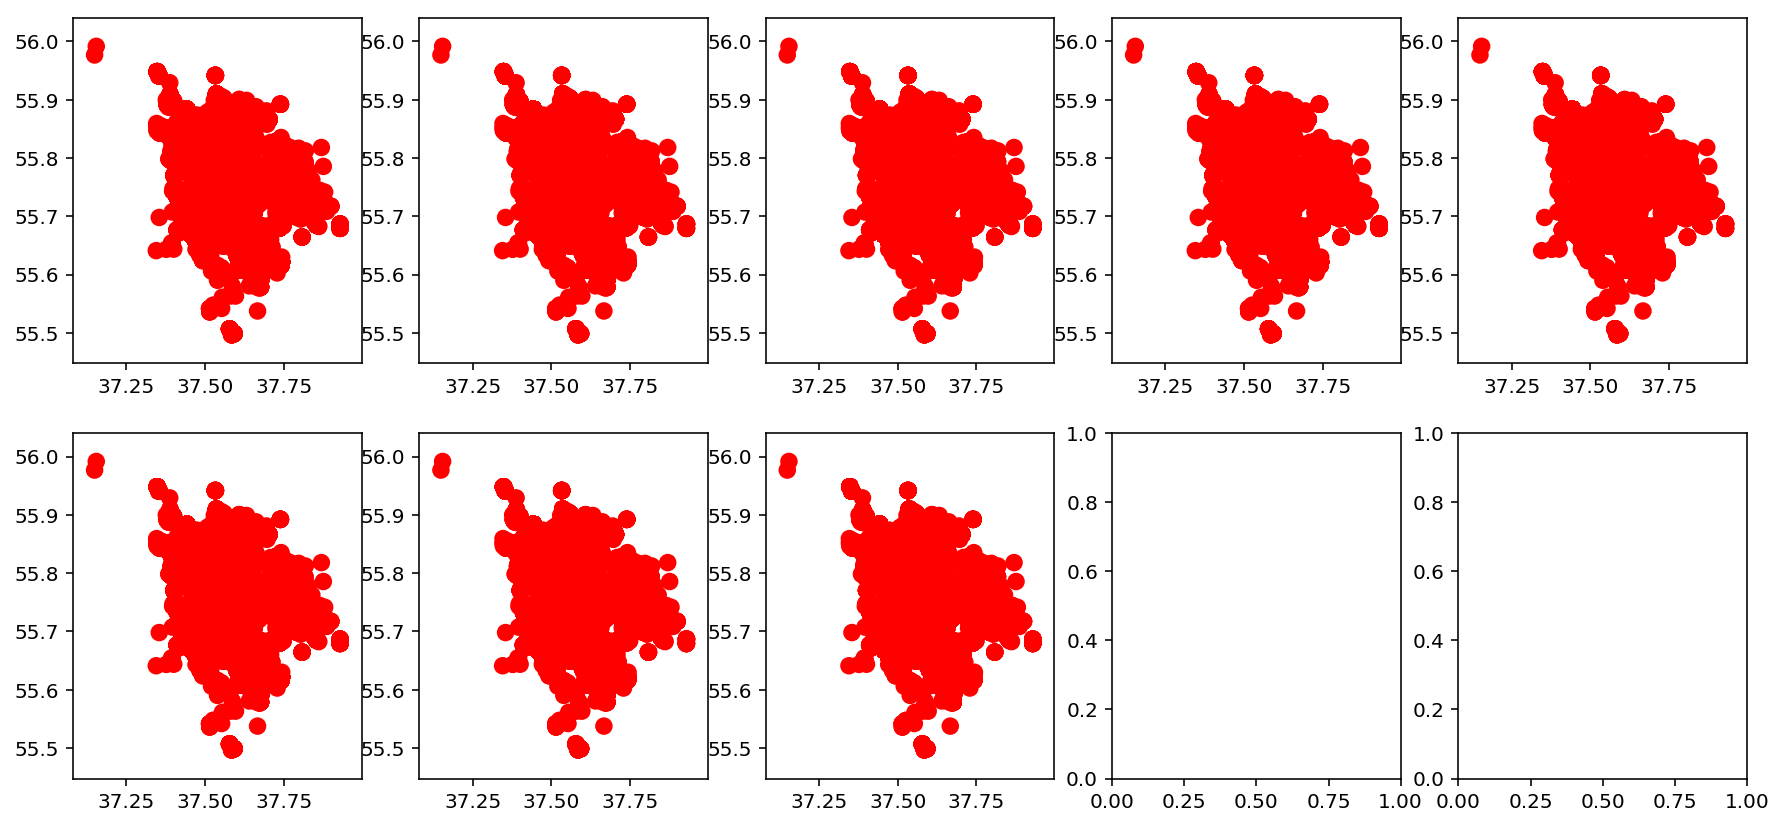

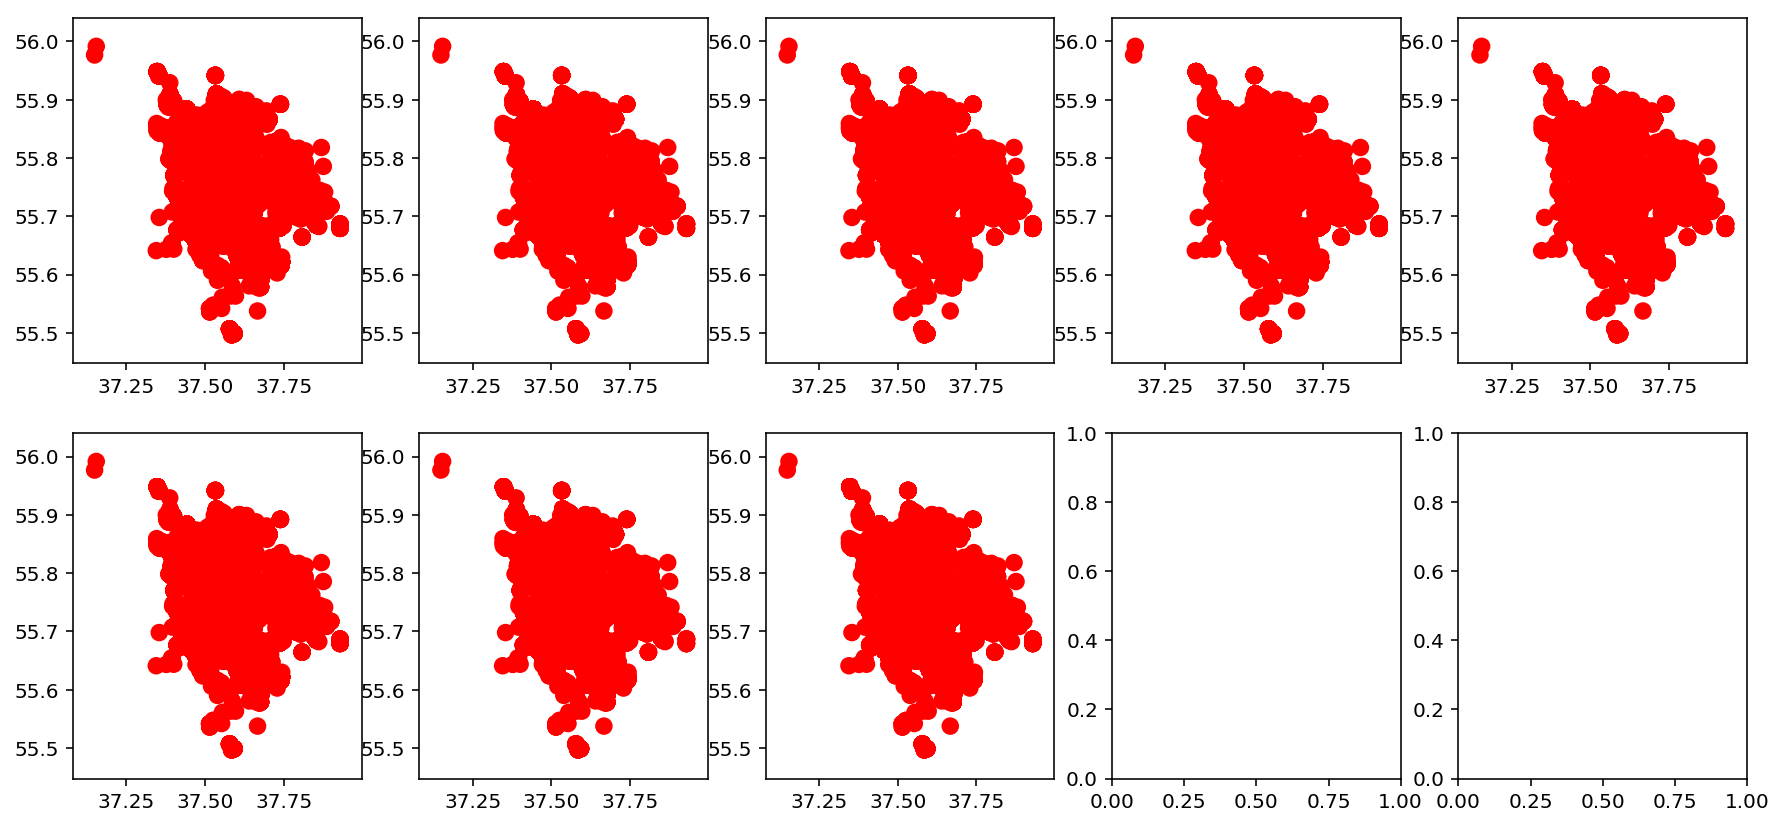

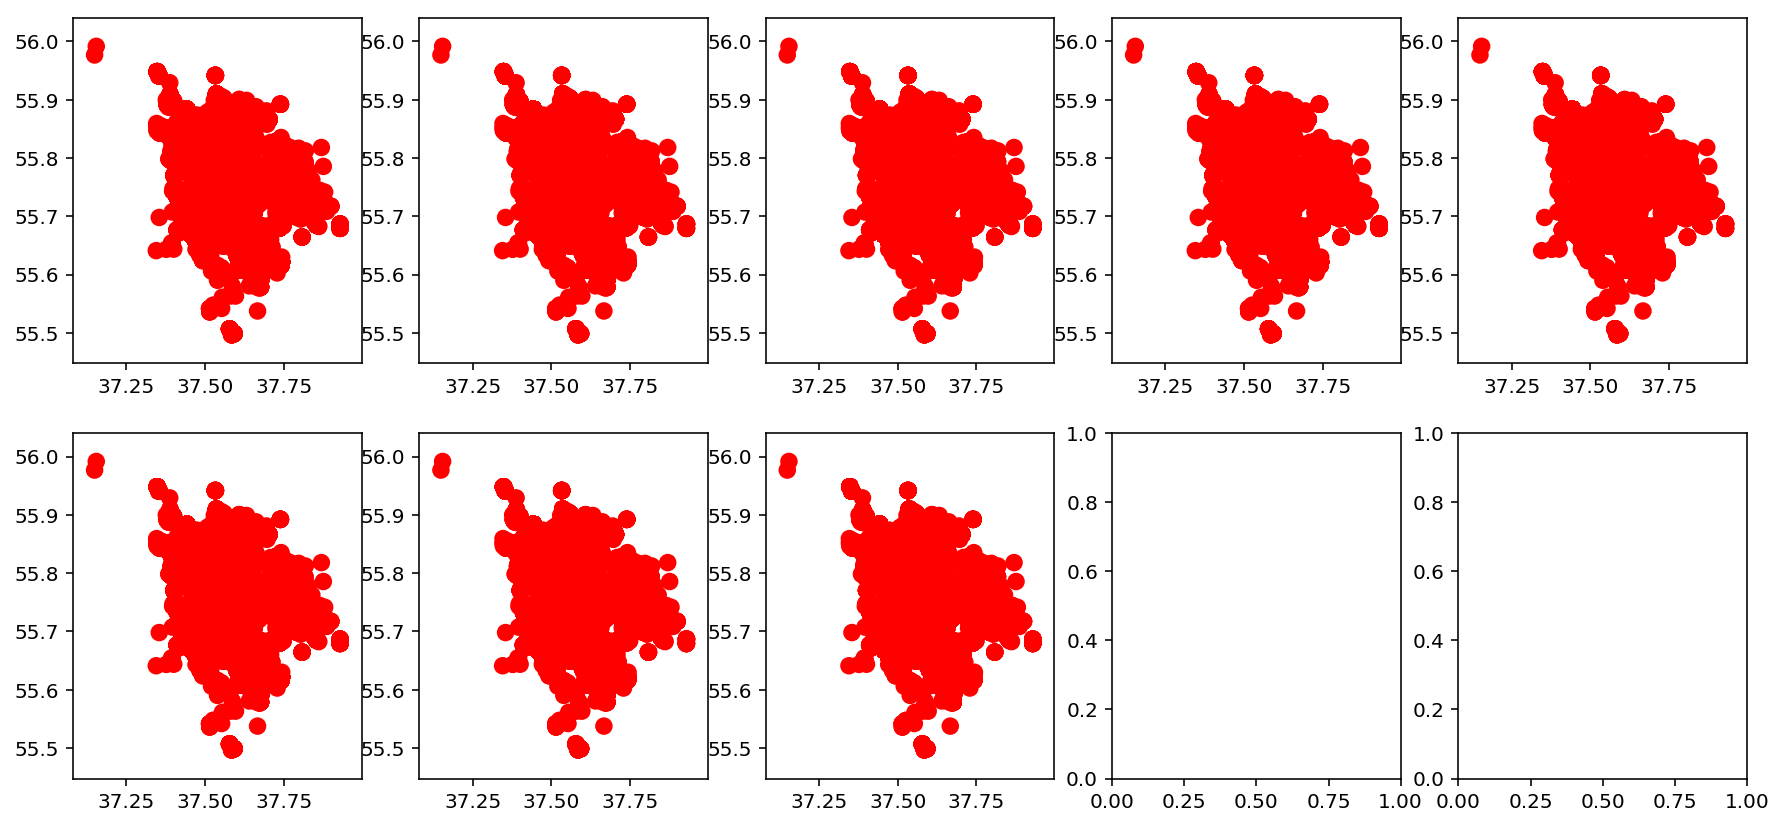

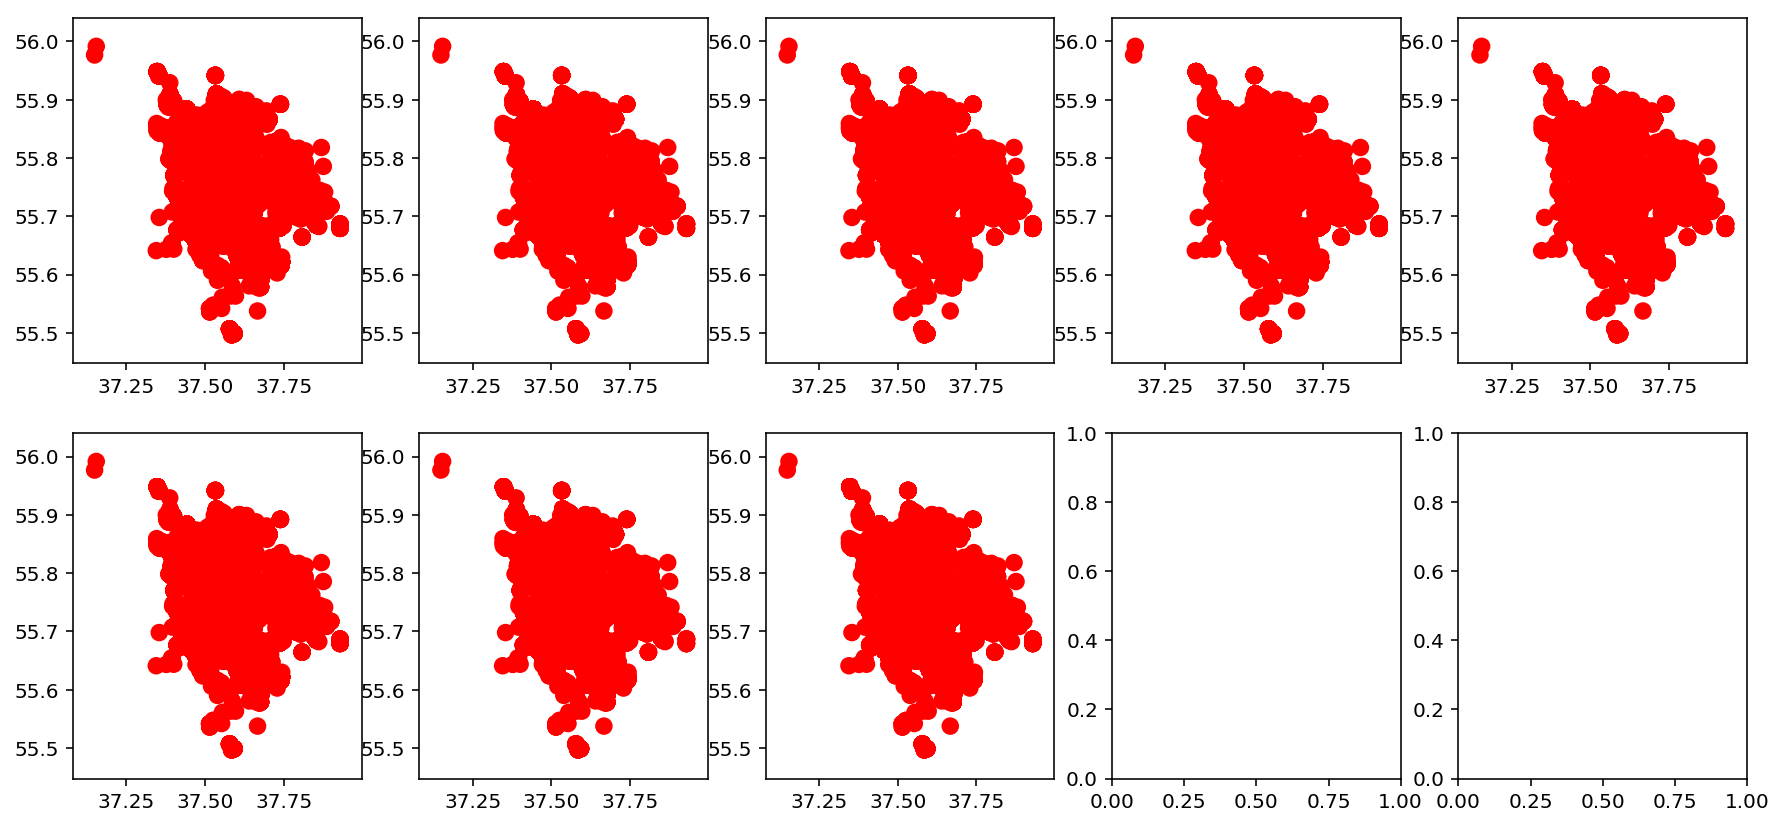

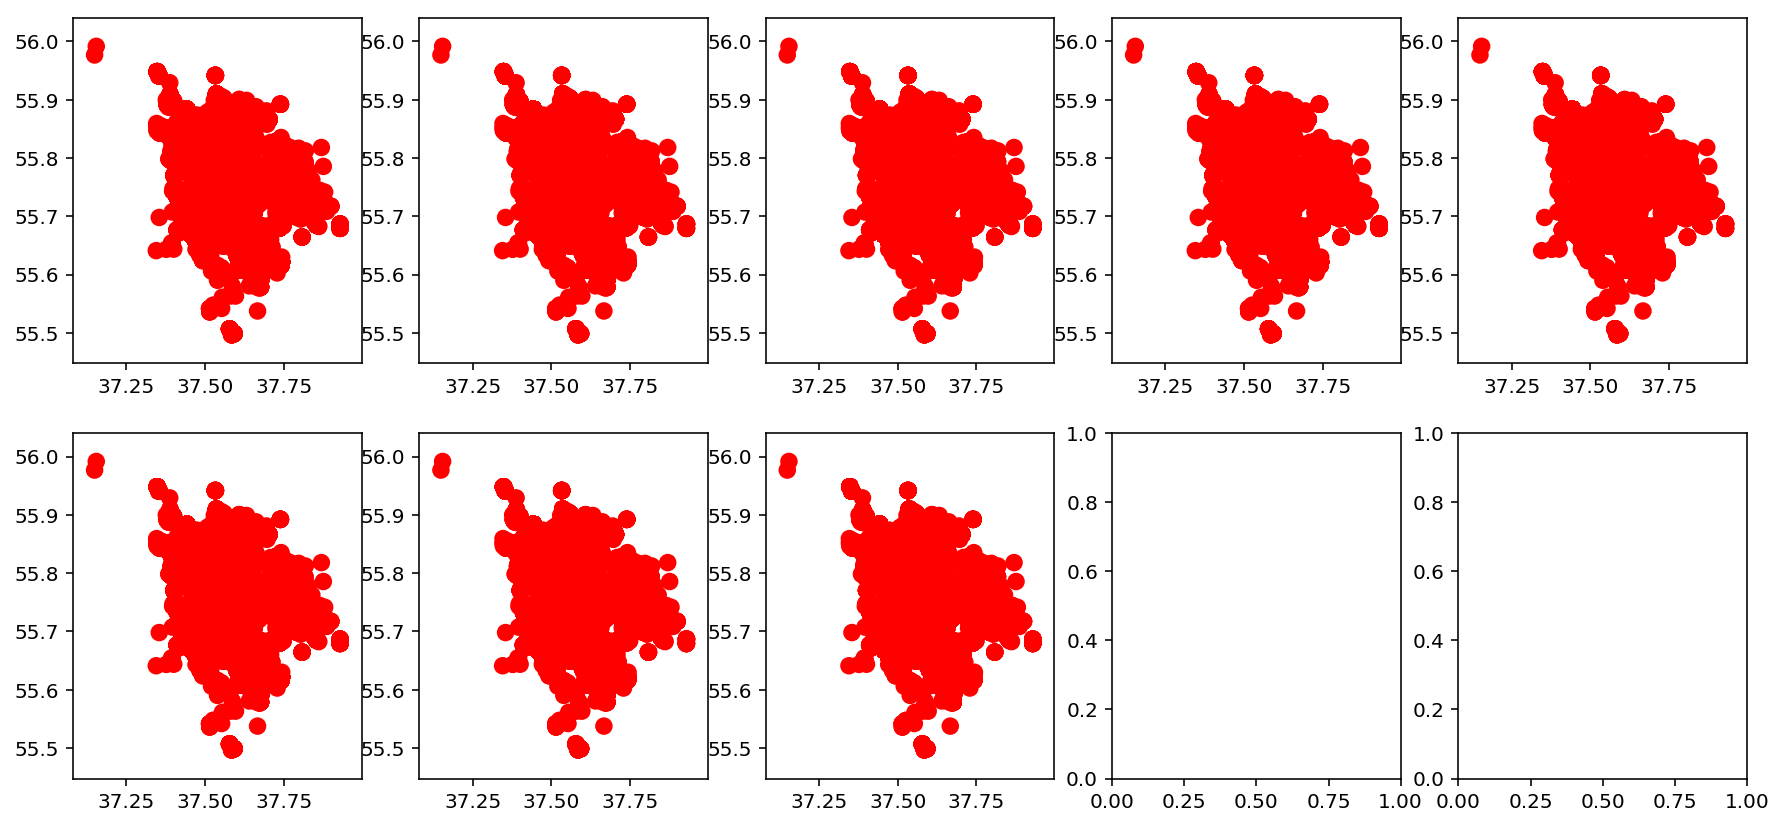

In [83]:
# посмотрим в каких диапазонах стоит подбирать значения
for k in eps_:
    fig, axes = plt.subplots(2,5 , figsize=(15,7))
    for ax, j in zip(fig.axes ,min_samples_):
        DB = DBSCAN(eps=k, min_samples=j, n_jobs=-1 )
        DB_clusters = DB.fit_predict(data_x)
        ax.scatter(data_x.x, data_x.y, c=DB_clusters, cmap='autumn', s=60)

Теперь найдём районы где голосовали активнее всего

### DBSCAN единичный, без сетки

In [27]:
choice = np.random.choice(data_prob.index, size=50000, replace=False).tolist()
data_50 = data_prob[data_prob.index.isin(choice)]

In [28]:
#               В данном примере со стандартицацией выходит хуже
# from sklearn.preprocessing import StandardScaler
# scal = StandardScaler()
# data_50_sc = scal.fit_transform(data_50)

In [29]:
db_classic = DBSCAN(eps=0.02, min_samples=500, n_jobs=-1 )

In [30]:
db_clusters = db_classic.fit_predict(data_50)

In [43]:
%matplotlib inline

![title](img/gmaps.png)

<img src= '../../gmaps.png'>

In [42]:
%matplotlib inline
import gmaps
gmaps.configure(api_key="My_API_Key")
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(data[['y', 'x']], opacity=0.6, max_intensity=40))
fig

Figure(layout=FigureLayout(height='420px'))

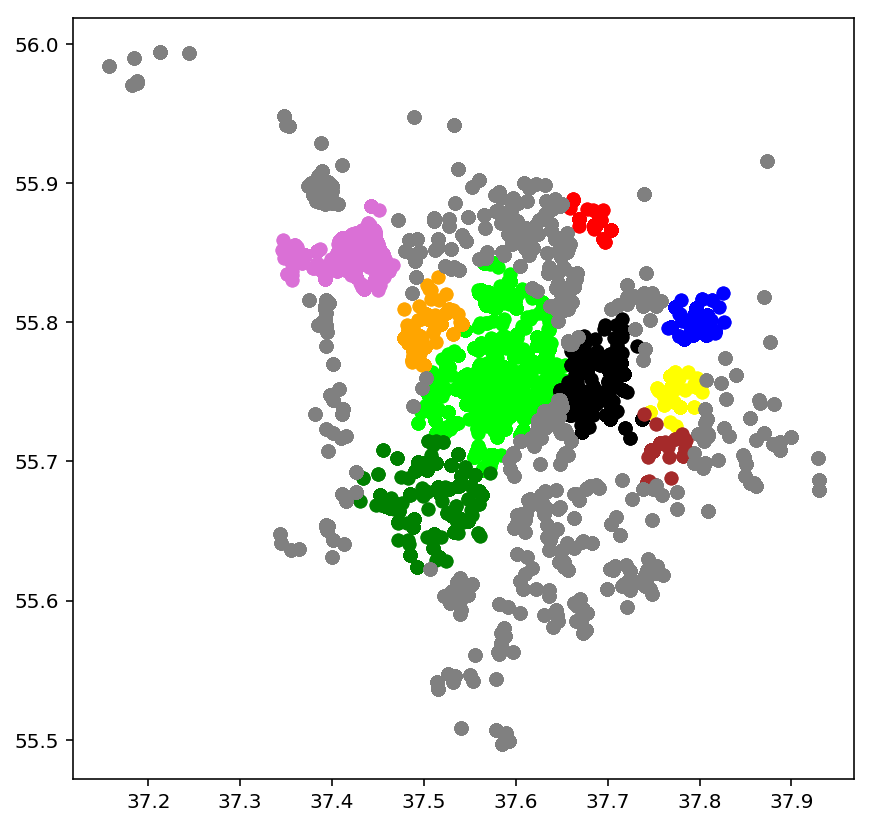

In [97]:
rcParams['figure.figsize'] = (7,7)
for i,color in zip(range(10),{'blue','red','green','black','orange','yellow','brown','orchid','lime'}):
    x_i = data_50.x[db_clusters==i]
    y_i = data_50.y[db_clusters==i]
    plt.plot(x_i, y_i, 'ro', c=color)
    plt.plot(x_i, y_i, 'ro', c=color)
    
    x_0 = data_50.x[db_clusters==-1]
    y_0 = data_50.y[db_clusters==-1]
    plt.plot(x_0, y_0, 'ro', c='grey')
    

## Теперь выделем основные тематики коментариев жителей(негативные)

In [2]:
df = pd.read_excel('geo_comment.xlsx')

In [3]:
df_n = df[df['comment_class']==-1]
df_n = df.drop(['x', 'y', 'comment_class'], axis=1)

In [2]:
!pip install pymorphy2 

  Using cached https://files.pythonhosted.org/packages/a3/33/fff9675c68b5f6c63ec8c6e6ff57827dda28a1fa5b2c2d727dffff92dd47/pymorphy2-0.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6a/84/ff1ce2071d4c650ec85745766c0047ccc3b5036f1d03559fd46bb38b5eeb/DAWG_Python-0.7.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/02/51/2465fd4f72328ab50877b54777764d928da8cb15b74e2680fc1bd8cb3173/pymorphy2_dicts-2.4.393442.3710985-py2.py3-none-any.whl


In [3]:
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [5]:
df_n.head(3)

,multiplier,comment
0,1,Во все разделы правил землепользования и застр...
1,1,На основании вступившего в законную силу судеб...
2,1,Внести в Проект правил землепользования и заст...


In [6]:
result = []
for i in df_n.comment:
    result.append(i)

In [7]:
# Обработоем полученное описание:
#                             - уберем все знаки препинания
#                             - уберем стоп-слова
#                             - нормализуем и сделаем стемминг

In [8]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
PortSt = PorterStemmer()
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Илья
[nltk_data]     Курошев\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Илья
[nltk_data]     Курошев\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [23]:
# clean_dict = []
clean_dict = {}
counter = 0

for number, doc in zip(range(50000), df_n.comment):
    body = doc
    body = re.sub('\[.*?\]','', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # делаем стемминг и нормализацию
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                filtered_tokens = []
                filtered_tokens.append(word)
                for t in filtered_tokens:
                    stems = stemmer.stem(t)
                    tokens.append(stems)
        # убираем стоп слова
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # убираем слова маленькой длины
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 500 == 0:
        print("{0} docs processed".format(counter))
    if counter == 50000: # для простоты расчета возьмем выборку из 50 000
        break
    clean_dict[number] = tokens
#     clean_dict.append(tokens)

clean_dict = {key: list(val) for key, val in clean_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed
2500 docs processed
2600 docs processed
2700 docs processed
2800 docs processed
2900 docs processed
3000 docs processed
3100 docs processed
3200 docs processed
3300 docs processed
3400 docs processed
3500 docs processed
3600 docs processed
3700 docs processed
3800 docs processed
3900 docs processed
4000 docs processed
4100 docs processed
4200 docs processed
4300 docs processed
4400 docs processed
4500 docs processed
4600 docs processed
4700 docs processed
4800 docs processed
4900 docs processed
5000 docs processed
5100 docs

39700 docs processed
39800 docs processed
39900 docs processed
40000 docs processed
40100 docs processed
40200 docs processed
40300 docs processed
40400 docs processed
40500 docs processed
40600 docs processed
40700 docs processed
40800 docs processed
40900 docs processed
41000 docs processed
41100 docs processed
41200 docs processed
41300 docs processed
41400 docs processed
41500 docs processed
41600 docs processed
41700 docs processed
41800 docs processed
41900 docs processed
42000 docs processed
42100 docs processed
42200 docs processed
42300 docs processed
42400 docs processed
42500 docs processed
42600 docs processed
42700 docs processed
42800 docs processed
42900 docs processed
43000 docs processed
43100 docs processed
43200 docs processed
43300 docs processed
43400 docs processed
43500 docs processed
43600 docs processed
43700 docs processed
43800 docs processed
43900 docs processed
44000 docs processed
44100 docs processed
44200 docs processed
44300 docs processed
44400 docs pr

In [29]:
from gensim.corpora import TextCorpus
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=clean_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=4, passes=30
)

In [30]:
# Получаем описание 4 тематик
print('LdaModel performance')
for i in range(4):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 объект земельн здан участк охра требу размещен сохран культурн наслед
1 прот категорическ территор возража строительств улиц документ существ площадк указа
2 окол площад предполага решен адрес помещен развит законодательств благоустройств дополнительн
3 прав соответств использован слушан публичн разрешен москв проект объект участк
